<a href="https://colab.research.google.com/github/mattrothery/dog-breed-classifier/blob/main/Dog_Breed_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dog Breed DNN Classifier using Inception V3

In [ ]:
# Import necessary packages, set TF version and load TensorBoard
%tensorflow_version 2.x
%load_ext tensorboard

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import datetime, os
import tensorflow_datasets as tfds

# Show runtime stats and clear TensorBoard logs
!nvidia-smi
!rm -rf logs

Wed Sep  8 14:43:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Download stanford dogs dataset and split into train, test, validation sets
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train+test[:85%]','train+test[85%:95%]', 'train+test[95%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

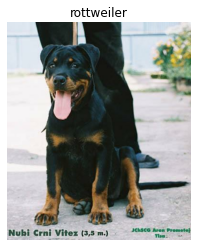

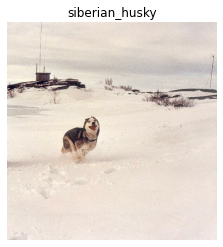

In [ ]:
# Function to extract label names
get_label_name = ds_info.features['label'].int2str  

# Display 2 images from the training dataset
for image, label in ds_train.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label).split('-', 1)[1])
    plt.axis("off")

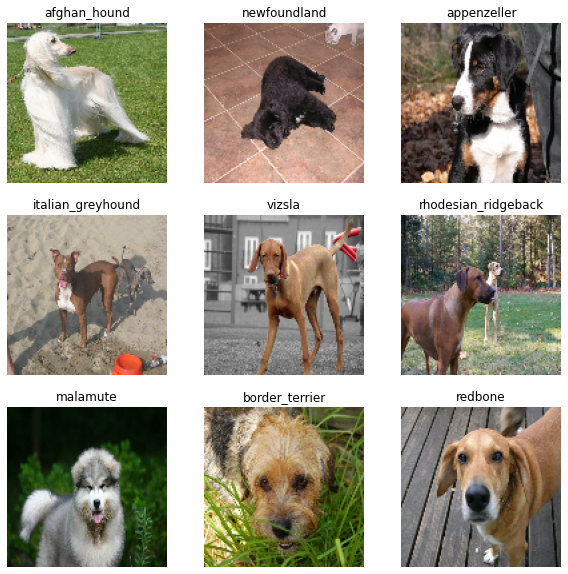

In [ ]:
IMG_SIZE = 120                   # Size to resize all images
SHUFFLE_BUFFER = len(ds_train)   # Ensure perfect shuffling
BATCH_SIZE = 20                  # Larger batch reduces epoch time
LEARNING_RATE = 0.01             # Starts high, but reduced through callback
EPOCHS = 50                      # More epochs may overfit


# Normalize images by casting to float, scaling between 0 and 1 and resizing
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

# Applying normalizing, shuffling, batching and prefetching to training dataset
ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

# For reference, show some of the normalized training images
plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(get_label_name(labels[i]).split('-', 1)[1])
    plt.axis("off")

# Now preprocessing the validation and test datasets
ds_val = ds_val.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.cache()
ds_val = ds_val.shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.cache()
ds_test = ds_test.batch(BATCH_SIZE)
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# Defining data augmentation layers to help classes that have low image counts
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.3, 0.2),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.2)
])

In [ ]:
# Defining input to model
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained Inception model
base_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
# Freeze all but top classification layer
base_model.trainable = False

In [ ]:
# Define model, including augmentation, base model, classicifation layers
model = tf.keras.Sequential([
    data_augmentation,
    base_model,
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(120)
])

# Show model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 120, 120, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2, 2, 2048)        21802784  
_________________________________________________________________
dropout (Dropout)            (None, 2, 2, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
batch_normalization_95 (Batc (None, 128)              

In [ ]:
# Compule model with Adam optimizer and appropriate classification loss metrics
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
# Set up TensorBoard logs path and callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Checkpointing callback path
checkpoint_path = "training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Define checkpointing, learning rate reduce and early stopping callbacks
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=0)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [ ]:
# Display Tensorboard. This may not show up if running for a second time
%tensorboard --logdir logs

In [ ]:
# Resume training from a saved model
# model = tf.keras.models.load_model('dog_classifier.h5')
# new_history = model.fit(ds_train,
#                         epochs=EPOCHS,
#                         validation_data=ds_val,
#                         callbacks=[tensorboard_callback, reduce_lr, cp_callback, es_callback])

In [ ]:
# Train the model with set hyperparameters and callbacks
history = model.fit(ds_train,
                    epochs=EPOCHS,
                    validation_data=ds_val,
                    callbacks=[tensorboard_callback, reduce_lr, cp_callback, es_callback])

Epoch 1/50
965/965 [==============================] - 125s 114ms/step - loss: 3.3702 - sparse_categorical_accuracy: 0.2046 - val_loss: 2.2350 - val_sparse_categorical_accuracy: 0.4032
Epoch 2/50
965/965 [==============================] - 85s 88ms/step - loss: 3.0016 - sparse_categorical_accuracy: 0.2639 - val_loss: 2.1257 - val_sparse_categorical_accuracy: 0.4310
Epoch 3/50
965/965 [==============================] - 82s 85ms/step - loss: 2.9398 - sparse_categorical_accuracy: 0.2767 - val_loss: 2.0894 - val_sparse_categorical_accuracy: 0.4425
Epoch 4/50
965/965 [==============================] - 82s 85ms/step - loss: 2.8987 - sparse_categorical_accuracy: 0.2862 - val_loss: 2.0720 - val_sparse_categorical_accuracy: 0.4557
Epoch 5/50
965/965 [==============================] - 83s 86ms/step - loss: 2.8484 - sparse_categorical_accuracy: 0.2889 - val_loss: 1.9440 - val_sparse_categorical_accuracy: 0.4688
Epoch 6/50
965/965 [==============================] - 82s 85ms/step - loss: 2.8131 - spa

In [ ]:
# Print overall test accuracy
test_loss, test_acc = model.evaluate(ds_test, verbose=2)
print(test_acc)

622/622 - 39s - loss: 1.6717 - sparse_categorical_accuracy: 0.5498
0.5497626662254333


In [ ]:
# Function to test our model on unseen image data (uploaded to runtime)
def test_unseen(model, img_path):
    # Load and preprocess image
    img = tf.keras.preprocessing.image.load_img(
        img_path, target_size=(IMG_SIZE, IMG_SIZE)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = tf.expand_dims(img_array, 0)

    # Generate predictions for the image and sort by top 5 highest probability
    predictions = model.predict(img_array)
    top_5 = np.argsort(-predictions[0])[:5]

    scores = tf.nn.softmax(predictions[0])
    top_5_scores = np.sort(-scores)[:5]

    results = zip(top_5, top_5_scores)
                                  
    # Show the image
    plt.figure()
    plt.imshow(img)
    plt.show()

    # Print the best prediction results, with class name and probability
    print('Predictions: ')
    for pred, score in results:
        print('{:.2f}%, {}'.format(100 * np.abs(score), get_label_name(pred).split('-', 1)[1]))

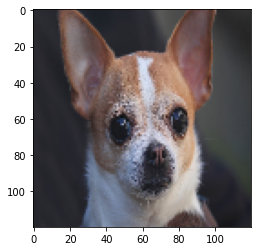

Predictions: 
63.53%, chihuahua
26.72%, toy_terrier
4.16%, french_bulldog
1.17%, mexican_hairless
0.75%, pembroke


In [ ]:
# Evaluate our model on an unseen dog image
test_unseen(model, 'dog6.jpg')

In [ ]:
# Save model to runtime. Can then be downloaded/copied to drive
model.save('dog_classifier.h5', overwrite=False)

[WARNING] dog_classifier.h5 already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True!
